In [1]:
# Ref: https://github.com/jupyter/notebook/issues/1290#issuecomment-204388895
# %env LD_LIBRARY_PATH=$PWD/../../../lib/:$LD_LIBRARY_PATH

## Testing BCM model on CIFAR-10 dataset

Now it is time to move to a more complex dataset.

Following the paper of [Krotov et al.](https://www.pnas.org/content/116/16/7723), a more complex dataset is given by the CIFAR-10.

In CIFAR-10 we have $50k$ ($32\times32$) RGB images, divided into $10$ classes.

The variability of the samples is higher in comparison with the MNIST dataset and the introduction of $3$ channels into the input drastically increase the number of parameters to learn.

We however try to memorize this dataset using the BCM model.

In this example we will use the `tensorflow` library for the download of the dataset.

The dataset is already divided into `train` and `test`, thus we will use only the `train` part for our application.

In [2]:
import tensorflow as tf

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

shape = x_train.shape[1:]
X = x_train.reshape(x_train.shape[0], -1)
X = X.astype(float)
X *= 1. / 255

x_train.shape

(50000, 32, 32, 3)

Now we can try to build our BCM model using different training parameters.

In particular, we increase the `batch_size`, since we want a faster convergence of the model.
We also use a `GlorotNormal` distribution for the weights initialization, since we have seen in the previous tutorial (ref. [BCM_on_MNIST](https://github.com/Nico-Curti/plasticity/tree/main/docs/source/examples/BCM_on_MNIST.ipynb)) that it should be a better choice than the classical `Normal` distribution.

To reach a reasonable result also the number of epochs must increase: in this case we use $100$ epochs of training.

CPU times: user 10d 6h 31min 39s, sys: 3d 13h 43min 55s, total: 13d 20h 15min 34s
Wall time: 1d 20h 22min 31s


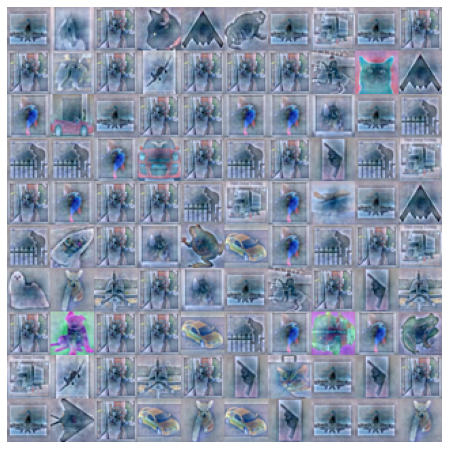

In [73]:
%%time
from plasticity.model import BCM
from plasticity.model.optimizer import Adam, Momentum, NesterovMomentum, SGD
from plasticity.model.weights import Normal, GlorotNormal, HeNormal, Zeros, Ones
from plasticity.model.weights import Uniform, LecunUniform, GlorotUniform, HeUniform
from plasticity.model.weights import Orthogonal

from plasticity.utils import view_weights

model = BCM(outputs=100, num_epochs=100000, 
            batch_size=X.shape[0], verbose=False,
            activation='Relu',
            optimizer=NesterovMomentum(lr=1e-3), 
            interaction_strength=-0.6,
            weights_init=Normal(mu=0., std=0.001),
            random_state=42 
            )
model.fit(X)

#view_weights(model.weights, dims=(32, 32, 3))
import numpy as np
import pylab as plt

num_images = int(np.sqrt(model.weights.shape[0]))
shape = (32, 32, 3)
selected_weights = model.weights[:num_images**2]
m = selected_weights.min(axis=1, keepdims=True)
M = selected_weights.max(axis=1, keepdims=True)
selected_weights = (selected_weights - m) * (1. / (M - m))

image = np.hstack(np.hstack(selected_weights.reshape(num_images, num_images, *shape)))
nc = np.max(np.abs(selected_weights))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
ax.axis('off')
im = ax.imshow(image, cmap='gray', vmin=0, vmax=nc)
#fig.colorbar(im, ticks=[np.min(selected_weights), 0, np.max(model.weights[:num_images**2])])

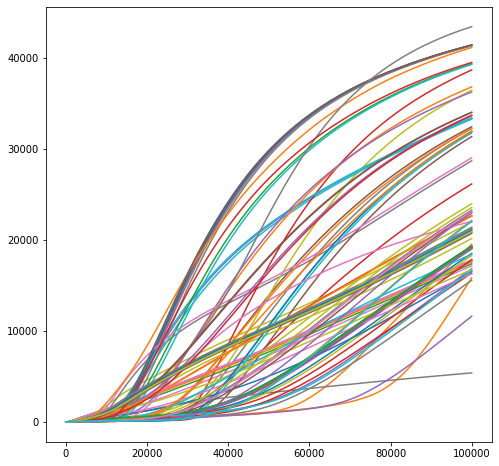

In [74]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
_ = ax.plot(model.history)

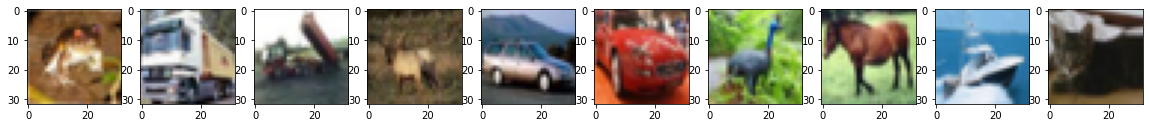

In [335]:
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(20, 20))
for ax, x in zip(axes, X):
    ax.imshow(x.reshape(32, 32, 3))

The result seems to be very dark...

However, seeing the warning raised by the function, there could be an issue in the visualization.

In this example we are using RGB images, i.e matrix of `uint8`.
Moreover the variability of the pixel values can be very high and a normalization according to the full set of weights can affect the constrast of the image.

We can re-write the `view_weights` using a standardization of the synaptic weights according to each neuron, rescaling the value into the range `[0, 255]` as `uint8`.

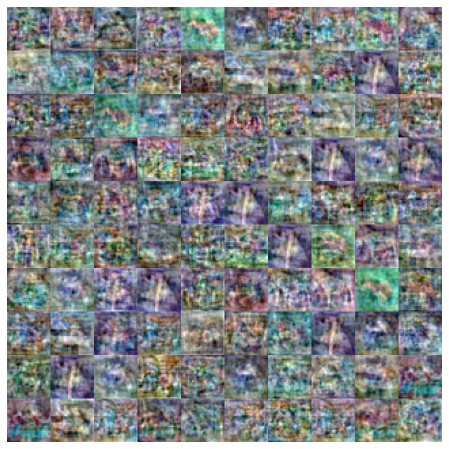

In [137]:
import numpy as np
import pylab as plt

num_images = int(np.sqrt(model.weights.shape[0]))
selected_weights = model.weights[:num_images**2]
m = selected_weights.min(axis=1, keepdims=True)
M = selected_weights.max(axis=1, keepdims=True)
selected_weights = (selected_weights - m) * (1. / (M - m))

image = np.hstack(np.hstack(selected_weights.reshape(num_images, num_images, *shape)))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
ax.axis('off')
im = ax.imshow(image)

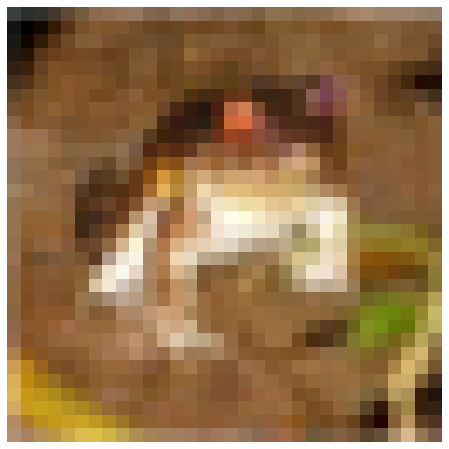

In [200]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
ax.axis('off')
im = ax.imshow(X[0, :].reshape(32, 32, 3))

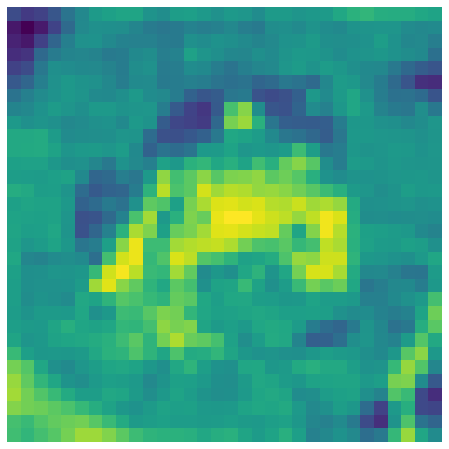

In [203]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
ax.axis('off')
im = ax.imshow(x_train[0, ..., 0].reshape(32, 32))